# **Computational Drug Discovery [Part 2] Exploratory Data Analysis**




We will be building a machine learning model using the ChEMBL bioactivity data.

In **Part 2**, we will be performing Descriptor Calculation and Exploratory Data Analysis.

---

In [1]:
from google.colab import drive

In [2]:
# Mount Google Drive
# This will prompt you to click a link, sign in, and paste an authorization code.
drive.mount('/content/drive')

Mounted at /content/drive


## **Install conda and rdkit**

In [67]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 56.1 MB/s eta 0:00:00


## **Load bioactivity data**

In [3]:
import sys
import pandas as pd
import numpy as np

In [34]:
bioactivities_df = pd.read_csv("/content/drive/My Drive/Data Science and ML courses/CADD/Raw_Data/BACE1_Modeling_data.csv")
bioactivities_df

,molecule_chembl_id,units,smiles,IC50_norm,pIC50,bioactivity_class
0,CHEMBL3969403,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...,2.000000e-04,12.698970,Active
1,CHEMBL3937515,nM,COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)...,9.000000e-04,12.045757,Active
2,CHEMBL3949213,nM,C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...,1.000000e-03,12.000000,Active
3,CHEMBL3955051,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3cnc(C(F)F)cn3...,1.800000e-03,11.744727,Active
4,CHEMBL3936264,nM,C[C@@]1(c2cc(NC(=O)c3ccc(OC(F)F)cn3)ccc2F)CS(=...,5.700000e-03,11.244125,Active
...,...,...,...,...,...,...
8166,CHEMBL5908501,nM,C[C@@]1(c2cc(NC(=O)c3cnc(OCC(F)(F)F)cn3)ccc2F)...,1.000000e+08,1.000000,Inactive
8167,CHEMBL5804713,nM,C[C@@]1(c2cc(NC(=O)c3ccc(F)cn3)cc(F)c2F)Cn2nnc...,1.000000e+08,1.000000,Inactive
8168,CHEMBL5758820,nM,NC1=N[C@](CF)(c2cc(NC(=O)c3ccc(F)cn3)ccc2F)Cn2...,1.000000e+08,1.000000,Inactive
8169,CHEMBL5983491,nM,C[C@@]1(c2cc(NC(=O)c3nn(C(F)F)cc3Cl)ccc2F)Cn2n...,1.000000e+08,1.000000,Inactive


### Redefining Bioactivity Classification with Stricter Thresholds

Based on our goal to identify only the most potent lead compounds, we are implementing a stricter classification threshold. We will first drop the existing 'bioactivity_class' column to start fresh.

The new, more stringent cutoffs are:
* Active: $\text{IC}_{50} \le 50 \text{ nM}$ (higher confidence of high potency)
* Inactive: $\text{IC}_{50} \ge 10000 \text{ nM}$ (industry standard for weak/inactive)
* Intermediate: Everything in between.

This ensures our machine learning model is trained on a cleaner set of high-quality positive examples.

In [37]:
df4 = bioactivities_df.copy()

In [50]:
# Drop the existing 'bioactivity_class'

df4 = df4.drop('bioactivity_class', axis=1)

In [51]:
df4.head()

,molecule_chembl_id,units,smiles,IC50_norm,pIC50
0,CHEMBL3969403,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...,0.0002,12.698970
1,CHEMBL3937515,nM,COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)...,0.0009,12.045757
2,CHEMBL3949213,nM,C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...,0.0010,12.000000
3,CHEMBL3955051,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3cnc(C(F)F)cn3...,0.0018,11.744727
4,CHEMBL3936264,nM,C[C@@]1(c2cc(NC(=O)c3ccc(OC(F)F)cn3)ccc2F)CS(=...,0.0057,11.244125


In [52]:

# Define the classification function based on pIC50 thresholds
# This function uses the pIC50 cutoffs for BACE-1 data.
def classify_bioactivity(pic50):
    """
    Classifies a compound's bioactivity based on the pIC50 value.
    pIC50 >= 7.3 (IC50 <= 1000 nM) is Active.
    pIC50 <= 5.0 (IC50 >= 10000 nM) is Inactive.
    """
    if pic50 >= 8.0:
        return "Active"
    elif pic50 <= 5.0:
        return "Inactive"
    else:
        # Compounds between 1000 nM and 10000 nM
        return "Intermediate"

In [53]:
# Apply the classification function to create the new column
# Note: We use the 'IC50_norm' column which holds nM values.
df4['bioactivity_class'] = df4['pIC50'].apply(classify_bioactivity)

In [54]:
# Display the new distribution and the modified DataFrame
print("\n--- New Distribution of Bioactivity Classes (IC50 <= 500 nM Active) ---")
print(df4['bioactivity_class'].value_counts())


--- New Distribution of Bioactivity Classes (IC50 <= 500 nM Active) ---
bioactivity_class
Intermediate    5832
Active          1459
Inactive         880
Name: count, dtype: int64


In [55]:
print("\nFirst 5 rows with the new classification:")
# Select and display the relevant columns
print(df4[['molecule_chembl_id', 'smiles', 'IC50_norm', 'pIC50', 'bioactivity_class']].head())


First 5 rows with the new classification:
  molecule_chembl_id                                             smiles  \
0      CHEMBL3969403  CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...   
1      CHEMBL3937515  COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)...   
2      CHEMBL3949213  C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...   
3      CHEMBL3955051  CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3cnc(C(F)F)cn3...   
4      CHEMBL3936264  C[C@@]1(c2cc(NC(=O)c3ccc(OC(F)F)cn3)ccc2F)CS(=...   

   IC50_norm      pIC50 bioactivity_class  
0     0.0002  12.698970            Active  
1     0.0009  12.045757            Active  
2     0.0010  12.000000            Active  
3     0.0018  11.744727            Active  
4     0.0057  11.244125            Active  


In [57]:
# Display the distribution and the modified DataFrame
print("Distribution of Bioactivity Classes:")
print(df4['bioactivity_class'].value_counts())

Distribution of Bioactivity Classes:
bioactivity_class
Intermediate    5832
Active          1459
Inactive         880
Name: count, dtype: int64


In [59]:
import pathlib as path

In [62]:
DRIVE_DIR = path.Path("/content/drive/My Drive/Data Science and ML courses/CADD/Data")

In [63]:
location = DRIVE_DIR / "Beta_Secretase1_bioactivities_dataset.csv"
df4.to_csv(location, index=False)

print(f"bioactivity dataset saved to: {location}")

bioactivity dataset saved to: /content/drive/My Drive/Data Science and ML courses/CADD/Data/Beta_Secretase1_bioactivities_dataset.csv


In [64]:
df_no_smiles = df4.drop(columns='smiles')

In [65]:
smiles = []

for i in df.smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [66]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,units,IC50_norm,pIC50,bioactivity_class,canonical_smiles
0,CHEMBL3969403,nM,2.000000e-04,12.698970,Active,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...
1,CHEMBL3937515,nM,9.000000e-04,12.045757,Active,COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)...
2,CHEMBL3949213,nM,1.000000e-03,12.000000,Active,C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...
3,CHEMBL3955051,nM,1.800000e-03,11.744727,Active,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3cnc(C(F)F)cn3...
4,CHEMBL3936264,nM,5.700000e-03,11.244125,Active,C[C@@]1(c2cc(NC(=O)c3ccc(OC(F)F)cn3)ccc2F)CS(=...
...,...,...,...,...,...,...
8166,CHEMBL5908501,nM,1.000000e+08,1.000000,Inactive,C[C@@]1(c2cc(NC(=O)c3cnc(OCC(F)(F)F)cn3)ccc2F)...
8167,CHEMBL5804713,nM,1.000000e+08,1.000000,Inactive,C[C@@]1(c2cc(NC(=O)c3ccc(F)cn3)cc(F)c2F)Cn2nnc...
8168,CHEMBL5758820,nM,1.000000e+08,1.000000,Inactive,NC1=N[C@](CF)(c2cc(NC(=O)c3ccc(F)cn3)ccc2F)Cn2...
8169,CHEMBL5983491,nM,1.000000e+08,1.000000,Inactive,C[C@@]1(c2cc(NC(=O)c3nn(C(F)F)cc3Cl)ccc2F)Cn2n...


## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

### **Import libraries**

In [68]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculate descriptors**

In [69]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [70]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,429.477,2.12408,2.0,7.0
1,435.481,1.65600,2.0,8.0
2,455.515,2.65828,2.0,7.0
3,455.462,2.58500,2.0,7.0
4,442.419,2.07520,2.0,7.0
...,...,...,...,...
8166,464.383,2.03490,2.0,9.0
8167,401.352,1.97700,2.0,7.0
8168,401.352,1.78750,2.0,7.0
8169,438.801,2.54880,2.0,8.0


In [76]:
location1 = DRIVE_DIR / "Beta_Secretase1_lipinski_dataset.csv"
df_lipinski.to_csv(location1, index=False)

print(f"lipinski dataset saved to: {location}")

lipinski dataset saved to: /content/drive/My Drive/Data Science and ML courses/CADD/Data/Beta_Secretase1_bioactivities_dataset.csv


### **Combine DataFrames**

Let's take a look at the 2 DataFrames that will be combined.

In [72]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,429.477,2.12408,2.0,7.0
1,435.481,1.65600,2.0,8.0
2,455.515,2.65828,2.0,7.0
3,455.462,2.58500,2.0,7.0
4,442.419,2.07520,2.0,7.0
...,...,...,...,...
8166,464.383,2.03490,2.0,9.0
8167,401.352,1.97700,2.0,7.0
8168,401.352,1.78750,2.0,7.0
8169,438.801,2.54880,2.0,8.0


In [73]:
df4

,molecule_chembl_id,units,smiles,IC50_norm,pIC50,bioactivity_class
0,CHEMBL3969403,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...,2.000000e-04,12.698970,Active
1,CHEMBL3937515,nM,COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)...,9.000000e-04,12.045757,Active
2,CHEMBL3949213,nM,C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...,1.000000e-03,12.000000,Active
3,CHEMBL3955051,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3cnc(C(F)F)cn3...,1.800000e-03,11.744727,Active
4,CHEMBL3936264,nM,C[C@@]1(c2cc(NC(=O)c3ccc(OC(F)F)cn3)ccc2F)CS(=...,5.700000e-03,11.244125,Active
...,...,...,...,...,...,...
8166,CHEMBL5908501,nM,C[C@@]1(c2cc(NC(=O)c3cnc(OCC(F)(F)F)cn3)ccc2F)...,1.000000e+08,1.000000,Inactive
8167,CHEMBL5804713,nM,C[C@@]1(c2cc(NC(=O)c3ccc(F)cn3)cc(F)c2F)Cn2nnc...,1.000000e+08,1.000000,Inactive
8168,CHEMBL5758820,nM,NC1=N[C@](CF)(c2cc(NC(=O)c3ccc(F)cn3)ccc2F)Cn2...,1.000000e+08,1.000000,Inactive
8169,CHEMBL5983491,nM,C[C@@]1(c2cc(NC(=O)c3nn(C(F)F)cc3Cl)ccc2F)Cn2n...,1.000000e+08,1.000000,Inactive


Now, let's combine the 2 DataFrame

In [74]:
df_combined = pd.concat([df4,df_lipinski], axis=1)

In [75]:
df_combined

,molecule_chembl_id,units,smiles,IC50_norm,pIC50,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL3969403,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...,2.000000e-04,12.698970,Active,429.477,2.12408,2.0,7.0
1,CHEMBL3937515,nM,COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)...,9.000000e-04,12.045757,Active,435.481,1.65600,2.0,8.0
2,CHEMBL3949213,nM,C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...,1.000000e-03,12.000000,Active,455.515,2.65828,2.0,7.0
3,CHEMBL3955051,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3cnc(C(F)F)cn3...,1.800000e-03,11.744727,Active,455.462,2.58500,2.0,7.0
4,CHEMBL3936264,nM,C[C@@]1(c2cc(NC(=O)c3ccc(OC(F)F)cn3)ccc2F)CS(=...,5.700000e-03,11.244125,Active,442.419,2.07520,2.0,7.0
...,...,...,...,...,...,...,...,...,...,...
8166,CHEMBL5908501,nM,C[C@@]1(c2cc(NC(=O)c3cnc(OCC(F)(F)F)cn3)ccc2F)...,1.000000e+08,1.000000,Inactive,464.383,2.03490,2.0,9.0
8167,CHEMBL5804713,nM,C[C@@]1(c2cc(NC(=O)c3ccc(F)cn3)cc(F)c2F)Cn2nnc...,1.000000e+08,1.000000,Inactive,401.352,1.97700,2.0,7.0
8168,CHEMBL5758820,nM,NC1=N[C@](CF)(c2cc(NC(=O)c3ccc(F)cn3)ccc2F)Cn2...,1.000000e+08,1.000000,Inactive,401.352,1.78750,2.0,7.0
8169,CHEMBL5983491,nM,C[C@@]1(c2cc(NC(=O)c3nn(C(F)F)cc3Cl)ccc2F)Cn2n...,1.000000e+08,1.000000,Inactive,438.801,2.54880,2.0,8.0


### **Removing the 'intermediate' bioactivity class**
Here, we will be removing the ``intermediate`` class from our data set.

In [77]:
df_combined = df_combined.drop(columns=['IC50_norm', 'units'])
display(df_combined.head())

,molecule_chembl_id,smiles,pIC50,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL3969403,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...,12.698970,Active,429.477,2.12408,2.0,7.0
1,CHEMBL3937515,COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)...,12.045757,Active,435.481,1.65600,2.0,8.0
2,CHEMBL3949213,C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...,12.000000,Active,455.515,2.65828,2.0,7.0
3,CHEMBL3955051,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3cnc(C(F)F)cn3...,11.744727,Active,455.462,2.58500,2.0,7.0
4,CHEMBL3936264,C[C@@]1(c2cc(NC(=O)c3ccc(OC(F)F)cn3)ccc2F)CS(=...,11.244125,Active,442.419,2.07520,2.0,7.0


In [82]:
df_twoclass = df_combined[df_combined['bioactivity_class'] != 'Intermediate']
df_twoclass

,molecule_chembl_id,smiles,pIC50,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL3969403,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...,12.698970,Active,429.477,2.12408,2.0,7.0
1,CHEMBL3937515,COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)...,12.045757,Active,435.481,1.65600,2.0,8.0
2,CHEMBL3949213,C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...,12.000000,Active,455.515,2.65828,2.0,7.0
3,CHEMBL3955051,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3cnc(C(F)F)cn3...,11.744727,Active,455.462,2.58500,2.0,7.0
4,CHEMBL3936264,C[C@@]1(c2cc(NC(=O)c3ccc(OC(F)F)cn3)ccc2F)CS(=...,11.244125,Active,442.419,2.07520,2.0,7.0
...,...,...,...,...,...,...,...,...
8166,CHEMBL5908501,C[C@@]1(c2cc(NC(=O)c3cnc(OCC(F)(F)F)cn3)ccc2F)...,1.000000,Inactive,464.383,2.03490,2.0,9.0
8167,CHEMBL5804713,C[C@@]1(c2cc(NC(=O)c3ccc(F)cn3)cc(F)c2F)Cn2nnc...,1.000000,Inactive,401.352,1.97700,2.0,7.0
8168,CHEMBL5758820,NC1=N[C@](CF)(c2cc(NC(=O)c3ccc(F)cn3)ccc2F)Cn2...,1.000000,Inactive,401.352,1.78750,2.0,7.0
8169,CHEMBL5983491,C[C@@]1(c2cc(NC(=O)c3nn(C(F)F)cc3Cl)ccc2F)Cn2n...,1.000000,Inactive,438.801,2.54880,2.0,8.0


Let's write this to CSV file.

In [83]:
location4 = DRIVE_DIR / "Beta_Secretase1_twoclasses_dataset_correct.csv"
df_twoclass.to_csv(location4, index=False)

print(f"Two class dataset saved to: {location4}")

Two class dataset saved to: /content/drive/My Drive/Data Science and ML courses/CADD/Data/Beta_Secretase1_bioactivities_dataset.csv


---

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

### **Import library**

In [80]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Frequency plot of the 2 bioactivity classes**

/tmp/ipython-input-2507970612.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='bioactivity_class', data=df_twoclass, edgecolor='black', palette=['skyblue', 'brown'])


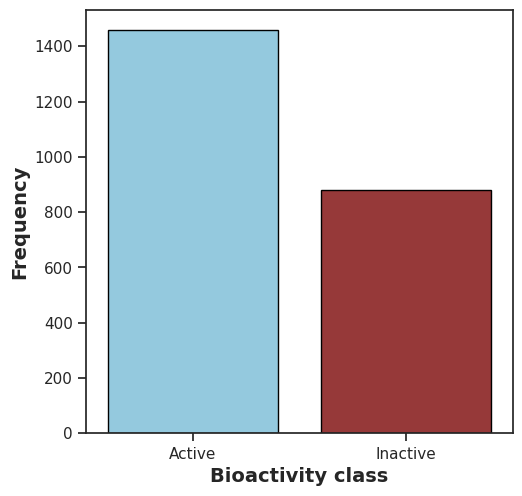

In [85]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_twoclass, edgecolor='black', palette=['skyblue', 'brown'])

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

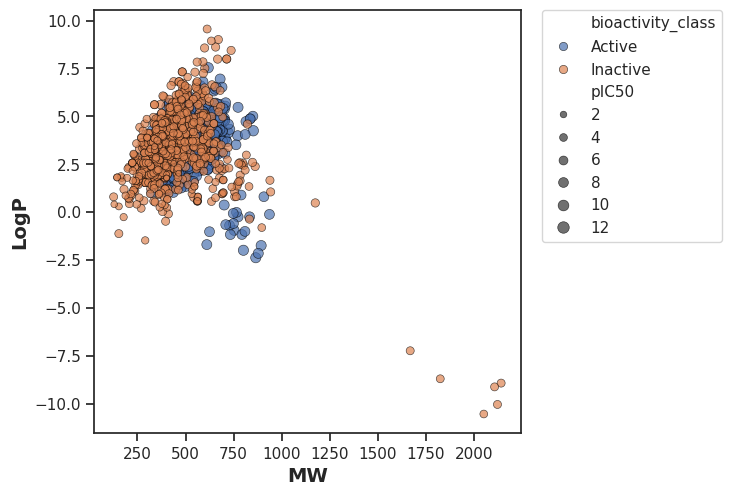

In [87]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_twoclass, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

### **Box plots**

#### **pIC50 value**

/tmp/ipython-input-1531143437.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_twoclass, palette=['skyblue', 'brown'])


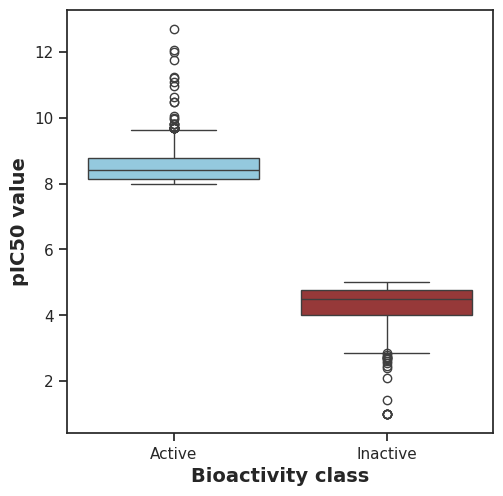

In [97]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_twoclass, palette=['skyblue', 'brown'])

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [92]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_twoclass[selection]
  active = df[df['bioactivity_class'] == 'Active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_twoclass[selection]
  inactive = df[df['bioactivity_class'] == 'Inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [93]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,1283920.0,0.0,0.05,Different distribution (reject H0)


#### **MW**

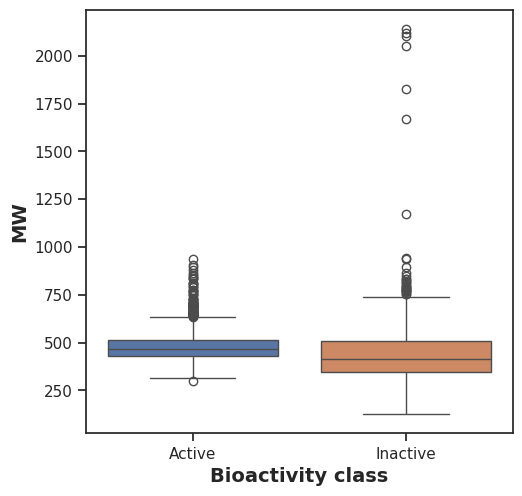

In [98]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_twoclass, hue='bioactivity_class', legend=False)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [95]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,850618.0,1.041776e-39,0.05,Different distribution (reject H0)


#### **LogP**

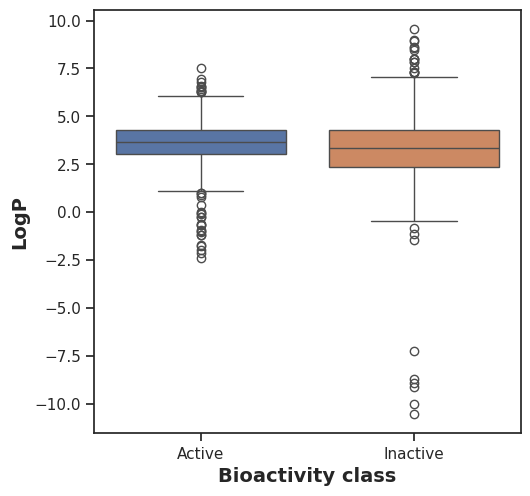

In [99]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_twoclass, hue='bioactivity_class', legend=False)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [100]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,728484.5,4.544365e-08,0.05,Different distribution (reject H0)


#### **NumHDonors**

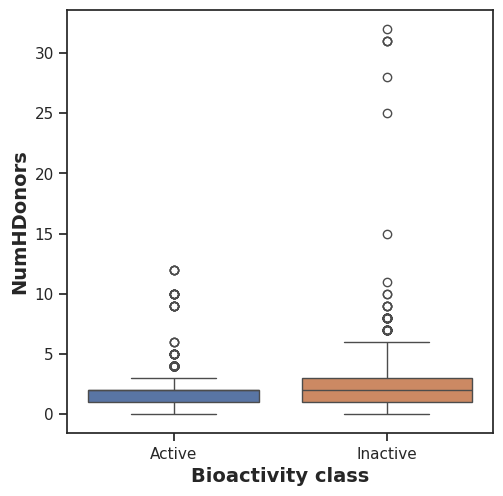

In [101]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_twoclass, hue='bioactivity_class', legend=False)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [102]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,546459.0,1.604864e-10,0.05,Different distribution (reject H0)


#### **NumHAcceptors**

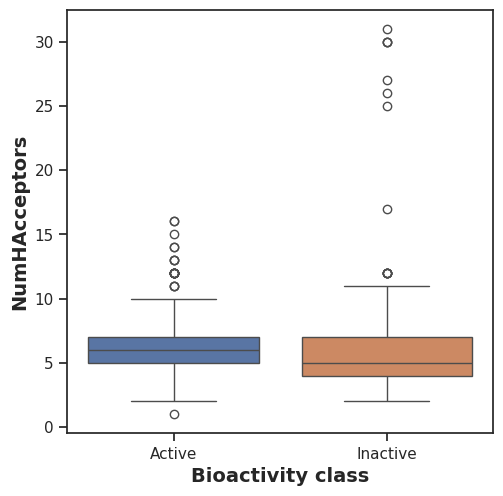

In [103]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_twoclass, hue='bioactivity_class', legend=False)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [104]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,833755.0,8.129959e-35,0.05,Different distribution (reject H0)


#### **Interpretation of Statistical Results**

##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

All of the 4 Lipinski's descriptors exhibited ***statistically significant difference*** between the **actives** and **inactives**.

## **Zip files**

In [105]:
! zip -r results.zip . -i *.csv *.pdf

	zip warning: name not matched: drive/MyDrive/BCH 802 Presentations/Group 5 edit. Microbial preparation of beer, wine, bread.pptx
	zip warning: name not matched: drive/MyDrive/BCH 802 Presentations/Group 2 methanogenesis updated.pptx
	zip warning: name not matched: drive/MyDrive/BCH 802 Presentations/Group 3 STRAIN IMPROVEMENT STRATEGIES.pptx
	zip warning: name not matched: drive/MyDrive/BCH 802 Presentations/Group 1 MICROBIAL PRODUCTION OF  PHARMACEUTICALS GROUP EDITED.pptx
	zip warning: name not matched: drive/MyDrive/BCH 802 Presentations/Group 4 GENE DOSAGE slide2-1.pptx
Scanning files .
	zip warning: name not matched: drive/.Encrypted/.shortcut-targets-by-id/1HSEZNHGhxZ44d0sJkxDvEk5RicLKbtss/Fall 2023 US Admission
  adding: plot_bioactivity_class.pdf (deflated 38%)
  adding: mannwhitneyu_pIC50.csv (deflated 8%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 11%)
  adding: plot_NumHDonors.pdf (deflated 38%)
  adding: plot_NumHAcceptors.pdf (deflated 39%)
  adding: plot_ic50.pdf (d